In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import ode_y, ode_y_jump_approach_one, ode_y_jump_approach_one_boundary
from utilities import find_nearest_value
from numba import njit

**ODE for y on (0, 2)**:
\begin{align*}
0 = \max_{\tilde{e}} \min_h &  -\delta \phi(y) + \delta \eta \log \tilde{e} \\
&+ \frac{d\phi(y)}{dy}\tilde{e}(\sum_{i=1}^n \pi_i^c \theta_i\ + \sigma_y \cdot h) + \frac{1}{2} \frac{d^2 \phi(y)}{(d y)^2}|\sigma_y|^2(\tilde{e})^2\\
&+ (\eta-1)(\gamma_1 + \gamma_2 y)\tilde{e}(\sum_{i=1}^n \pi_i^c \theta_i\ + \sigma_y \cdot h)\\
& +\frac{\xi_{1,m}}{2}h^\prime h + \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)\\
& + \mathcal{I}(y) \sum_{j=1}^m \hat{\pi}_j^d g_j [\phi_j(y)-\phi(y)] + \xi_{2,m} \mathcal{I}(y)\sum_{j=1}^m \hat{\pi}_j^d \left[1- g_j + g_j \log g_j\right]
\end{align*}

where
$$
\mathcal{I}(y) = \frac{1}{\sqrt{2\pi}\varsigma}\exp\{-\frac{(\bar{y}-y)^2}{2\varsigma^2}\}
$$

The FOC of $h$ gives:
$$
h^* = -\frac{\left(\frac{d\phi(y)}{dy} + (\eta-1)(\gamma_1 + \gamma_2 y )\right)\tilde{e}\sigma_y}{\xi_{1,m}}
$$


Substitute $h$ with $h^*$ in the ODE:

\begin{align*}
0 = \max_{\tilde{e}} & -\delta \phi(y) + \delta \eta \log \tilde{e} \\
& + G(y)\tilde{e}\sum_{i=1}^n \pi^c_i\theta_i + \frac{1}{2} \left(\frac{d^2 \phi(y)}{(d y)^2}-\frac{G^2(y)}{\xi_{1,m}}\right)|\sigma_y|^2(\tilde{e})^2\\
&+ \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)\\
& + \mathcal{I}(y) \sum_{j=1}^m \hat{\pi}_j^d g_j [\phi_j(y)-\phi(y)] + \xi_{2,m} \mathcal{I}(y)\sum_{j=1}^m \hat{\pi}_j^d \left[1- g_j + g_j \log g_j\right]
\end{align*}

where $G(y):=\frac{d\phi(y)}{dy} + (\eta-1)(\gamma_1 + \gamma_2 y)$

The FOC of $\tilde{e}$ gives:
$$
\tilde{e}^* = \frac{-\sum_{i=1}^n\pi^c_i \theta_i G(y) + \sqrt{\left(\sum_{i=1}^n \pi_i^c \theta_i\right)^2G^2(y)-4\delta \eta |\sigma_y|^2\left(\frac{d^2\phi(y)}{(dy)^2}-\frac{G^2(y)}{\xi_m}\right)}}{2|\sigma_y|^2\left(\frac{d^2\phi(y)}{(dy)^2}-\frac{G^2(y)}{\xi_{1,m}}\right)}
$$

In addition, the FOC of $\pi^c_i$ gives:
$$
\pi_i^c \propto \exp \left[-\frac{1}{\xi_a}G(y)\tilde{e}\theta_i\right]\hat{\pi}^c_i
$$

The FOC of $g_j$ gives:
$$
g_j = \exp \left(-\frac{1}{\xi_m}[\phi_j(y)-\phi(y)]\right)
$$

In [2]:
ξ_1m = 1./400
ξ_a = 1000

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*1.86/1000

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2])
πd_o = np.array([.5, .5])
# γ_2p = np.array([0, .0197*2, .3853*2])
# πd_o = np.array([.475, .475, .05])

y_step = .02
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

In [3]:
# Prepare ϕ
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                       tol=1e-8, max_iter=10_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i = np.array(ϕ_list_short)

Converged. Total iteration 10000: LHS Error: 1.453751923313762e-06; RHS Error 7.880238624667375e-07
Converged. Total iteration 2068: LHS Error: 9.956630513119347e-09; RHS Error 4.406953638417079e-06


In [4]:
# Compute ϕ
ς = .25
ξ_2m = ξ_1m*5
model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, v0=np.average(ϕ_i, weights=πd_o, axis=0),
                                                    ϵ=.5, tol=1e-9, max_iter=10000, print_all=True)

Iteration 1: LHS Error: 0.011583576847400065; RHS Error 8.819835569081605e-05
Iteration 2: LHS Error: 0.0011717938414349538; RHS Error 0.0012391859712431099
Iteration 3: LHS Error: 0.0009190863134139332; RHS Error 0.0008192015581098107
Iteration 4: LHS Error: 0.0007806361655629535; RHS Error 0.0006905554693218777
Iteration 5: LHS Error: 0.0006946504036767637; RHS Error 0.0006397205626030258
Iteration 6: LHS Error: 0.0006339455800134508; RHS Error 0.0006073428550616905
Iteration 7: LHS Error: 0.0005831351003758312; RHS Error 0.00057815835886342
Iteration 8: LHS Error: 0.0005428410699515121; RHS Error 0.0005488912122583985
Iteration 9: LHS Error: 0.0005052461234163058; RHS Error 0.0005186443283763227
Iteration 10: LHS Error: 0.00048084180481285793; RHS Error 0.0004873107798116941
Iteration 11: LHS Error: 0.00047169763350234095; RHS Error 0.00045478359766401257
Iteration 12: LHS Error: 0.0004609189665056232; RHS Error 0.00043543369052283237
Iteration 13: LHS Error: 0.00044568826670896705;

Iteration 131: LHS Error: 0.00010014627696965095; RHS Error 9.752043147902105e-05
Iteration 132: LHS Error: 9.941415453661173e-05; RHS Error 9.684540415897438e-05
Iteration 133: LHS Error: 9.854787789299879e-05; RHS Error 9.604038607936719e-05
Iteration 134: LHS Error: 9.779517505260904e-05; RHS Error 9.524904996246266e-05
Iteration 135: LHS Error: 9.705402684032083e-05; RHS Error 9.456425774328488e-05
Iteration 136: LHS Error: 9.618294979271691e-05; RHS Error 9.375354887135594e-05
Iteration 137: LHS Error: 9.551488164692701e-05; RHS Error 9.30470751816116e-05
Iteration 138: LHS Error: 9.476159084463587e-05; RHS Error 9.234958734997533e-05
Iteration 139: LHS Error: 9.394906128372404e-05; RHS Error 9.152991299287919e-05
Iteration 140: LHS Error: 9.329887241935064e-05; RHS Error 9.090821584838187e-05
Iteration 141: LHS Error: 9.253068998942016e-05; RHS Error 9.019544723535525e-05
Iteration 142: LHS Error: 9.181147095560505e-05; RHS Error 8.94454947008049e-05
Iteration 143: LHS Error: 9.1

Iteration 247: LHS Error: 4.409169050291484e-05; RHS Error 4.339308130120402e-05
Iteration 248: LHS Error: 4.381589294402688e-05; RHS Error 4.31318975012379e-05
Iteration 249: LHS Error: 4.353412098630216e-05; RHS Error 4.285748158674844e-05
Iteration 250: LHS Error: 4.3251425529397536e-05; RHS Error 4.259478023724988e-05
Iteration 251: LHS Error: 4.2981503808686705e-05; RHS Error 4.233204011462653e-05
Iteration 252: LHS Error: 4.269963698541601e-05; RHS Error 4.206205313143148e-05
Iteration 253: LHS Error: 4.243314708013424e-05; RHS Error 4.181076074903016e-05
Iteration 254: LHS Error: 4.216302752550749e-05; RHS Error 4.154852684812153e-05
Iteration 255: LHS Error: 4.188851372947944e-05; RHS Error 4.129321380193056e-05
Iteration 256: LHS Error: 4.16298747256405e-05; RHS Error 4.104241216967624e-05
Iteration 257: LHS Error: 4.13612664857399e-05; RHS Error 4.0782314483882136e-05
Iteration 258: LHS Error: 4.109972355034741e-05; RHS Error 4.053934768199086e-05
Iteration 259: LHS Error: 4.

Iteration 373: LHS Error: 2.977206530127563e-07; RHS Error 3.3860122304837405e-06
Iteration 374: LHS Error: 3.09995562684795e-07; RHS Error 3.420558489584621e-06
Iteration 375: LHS Error: 4.120749533612078e-07; RHS Error 3.4548435974301496e-06
Iteration 376: LHS Error: 7.508383558715859e-07; RHS Error 3.497582776214314e-06
Iteration 377: LHS Error: 1.924830227963137e-06; RHS Error 3.5838436516959574e-06
Iteration 378: LHS Error: 4.1560027890658047e-07; RHS Error 3.408162113495688e-06
Iteration 379: LHS Error: 5.350804017020816e-07; RHS Error 3.4360947700805625e-06
Iteration 380: LHS Error: 6.411297504560487e-07; RHS Error 3.4404388233839423e-06
Iteration 381: LHS Error: 7.197095847899515e-07; RHS Error 3.4456321953967592e-06
Iteration 382: LHS Error: 8.126689042334267e-07; RHS Error 3.4548974015566683e-06
Iteration 383: LHS Error: 9.473517719876812e-07; RHS Error 3.4676031043390384e-06
Iteration 384: LHS Error: 1.214915649555559e-06; RHS Error 3.4801469947001447e-06
Iteration 385: LHS 

Iteration 504: LHS Error: 8.776954954492489e-09; RHS Error 3.7708666519338106e-06
Iteration 505: LHS Error: 8.673425450078653e-09; RHS Error 3.7705869602627285e-06
Iteration 506: LHS Error: 8.564952497236433e-09; RHS Error 3.7702949449366376e-06
Iteration 507: LHS Error: 8.461619627198047e-09; RHS Error 3.7704267921235602e-06
Iteration 508: LHS Error: 8.36043916041529e-09; RHS Error 3.7710516061164765e-06
Iteration 509: LHS Error: 8.257840564129815e-09; RHS Error 3.7706356983277446e-06
Iteration 510: LHS Error: 8.163328527044378e-09; RHS Error 3.7706774818961034e-06
Iteration 511: LHS Error: 8.062207915160435e-09; RHS Error 3.769632461982726e-06
Iteration 512: LHS Error: 7.972709548109691e-09; RHS Error 3.7695165998840024e-06
Iteration 513: LHS Error: 7.87362414156334e-09; RHS Error 3.7685982926531267e-06
Iteration 514: LHS Error: 7.789637282429318e-09; RHS Error 3.76915001907603e-06
Iteration 515: LHS Error: 7.69288865942741e-09; RHS Error 3.7696915286230853e-06
Iteration 516: LHS Err

Iteration 628: LHS Error: 1.2389735487561282e-09; RHS Error 3.770672134093011e-06
Iteration 629: LHS Error: 2.9678822524581427e-09; RHS Error 3.770723962749124e-06
Iteration 630: LHS Error: 4.510222924303253e-09; RHS Error 3.769982449011234e-06
Iteration 631: LHS Error: 3.925624450507037e-09; RHS Error 3.7705731980423613e-06
Iteration 632: LHS Error: 1.3538023757586615e-09; RHS Error 3.77121229368357e-06
Iteration 633: LHS Error: 2.414876631995355e-09; RHS Error 3.771584584404716e-06
Iteration 634: LHS Error: 1.4647468307704692e-09; RHS Error 3.772216920081917e-06
Iteration 635: LHS Error: 2.2005179275974562e-09; RHS Error 3.772388959277686e-06
Iteration 636: LHS Error: 1.901666199510821e-09; RHS Error 3.7724294969224874e-06
Iteration 637: LHS Error: 1.2388966866283546e-09; RHS Error 3.772448829536827e-06
Iteration 638: LHS Error: 2.6786733317574196e-09; RHS Error 3.7727065093599984e-06
Iteration 639: LHS Error: 1.8096295226199821e-09; RHS Error 3.7721705625001897e-06
Iteration 640: LH

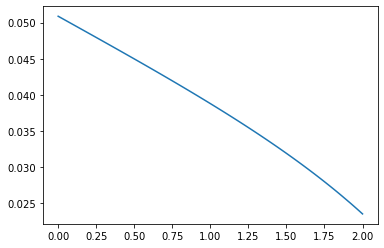

In [5]:
plt.plot(y_grid_short, model_res['v0'])

In [ ]:
plt.plot(y_grid_short, model_res['e_tilde'])
plt.title(r'$\tilde{f}$')
plt.xlabel('y')

In [ ]:
plt.plot(y_grid_short, model_res['v0'])
plt.xlabel('y')
plt.title('Figure 3: value funciton, 174th iteration')
# plt.savefig('fig_3.pdf')

In [ ]:
# Compute worst case probabilities
πd_o_reshape = np.zeros((len(πd_o), len(y_grid_short)))
for i in range(πd_o_reshape.shape[0]):
    πd_o_reshape[i] = πd_o[i]
πd = [np.exp(1./ξ_2m*(ϕ-ϕ_i[i])) * πd_o[i] for i in range(len(πd_o))]
πd = np.array(πd)

In [ ]:
def simulation(y_grid, e_grid, π_grid, g_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    πt = np.zeros((len(π_grid), T+1))
    yt = np.zeros(T+1)
    gt = np.zeros_like(πt)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        for n in range(πt.shape[0]):
            πt[n, i] = np.interp(y_start, y_grid, π_grid[n])
            gt[n, i] = np.interp(y_start, y_grid, g_grid[n])
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, πt, gt

In [ ]:
Et, yt, πt, gt = simulation(y_grid_short, e_tilde, πd, g, θ=1.86/1000., y_start=.5394, T=180)

In [ ]:
plt.plot(np.average(gt, axis=0, weights=πd_o))
plt.title('Approach one: proportional change in intensity')
plt.xlabel('Year')
plt.savefig('plot.pdf')

In [ ]:
plt.plot(πt[0], label='approach one')
# plt.plot(check[0], label='approach two')
plt.ylim(0, 0.5)
plt.title('Worst-case probability of low damage')
plt.legend()
plt.xlabel('Year')
plt.savefig('plot.pdf')

In [ ]:
plt.plot(yt)
plt.title('y')
plt.xlabel('Year')

In [ ]:
yt[-8]